# heterograph: visualisation

HGraph can be visualized using a built-in web app. As an example, consider the following graph:

In [1]:
from heterograph import *

g=HGraph()
g.add_vx(6)
g.add_edge(0, [1,2,3])
g.add_edge([1, 2, 3], 4)
g.add_edge(4, 5);

## rendering

### single graph
To simplest way to visualise a graph, is to use the `view(host='0.0.0.0', port='8888')` method. This launches a web app that can be accessed at `http://localhost:8888`. The web app allows zooming and panning. Note that, when this method is invoked inside a Jupyter Notebook, the graph is displayed directly within the notebook.

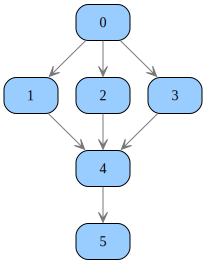

In [2]:
g.view()

### multiple graphs

The web application is capable of visualizing multiple graphs. To do this, we first need to create an instance of the `WebView` object, and then proceed to add the graphs to it.

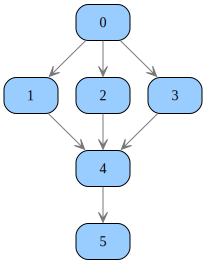

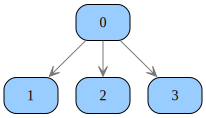

In [3]:
# copy part of the graph
h = g.copy(vs=[0, 1, 2, 3])

viewer=WebView()
viewer.add_graph(g, title="graph g")
viewer.add_graph(h, title="graph h")
viewer.run()

When running this code on a web browser (default: http://localhost:8888), the following screen appears:

<img src="images/webapp.png" width="500"/>

## graph styles

We can customize the rendering of the graphs by modifying the style attributes of the graph, vertex, and edge elements. Since the graphs are rendered using Graphviz, most of the attributes described in the [Graphviz documentation](https://graphviz.org/doc/info/attrs.html) are supported.

Styles can be directly encoded in an `HGraph` instance using the following properties:
   - `g.style`: This property controls the style attributes of the graph.
   - `g.vstyle`: This property controls the style attributes of the vertices.
   - `g.estyle`: This property controls the style attributes of the edges.

Each of these properties is a key-value pair structure similar to a `dict` (however, behaves differently when updating), where the key is the attribute name and the value is the corresponding attribute value. It is important to note that unlike property maps, there is only one global `vstyle` and `estyle` data structure that applies to all vertices and edges. However, as we shall see later, it is possible to customize these for specific vertices and edges.

### getting and setting styles

In [4]:
print(f"default graph styles:\n\t=> {g.style}")
print(f"default vertex styles:\n\t=> {g.vstyle}")
print(f"default edge styles:\n\t=> {g.estyle}")


default graph styles:
	=> {'layout': 'dot', 'rankdir': 'TD'}
default vertex styles:
	=> {'shape': 'Mrecord', 'style': 'filled', 'fillcolor': '#99CCFF', 'label': <function HGraph.__reset.<locals>.<lambda> at 0x7f0e7b607240>}
default edge styles:
	=> {'color': '#777777', 'arrowhead': 'open'}


These three properties function similarly to a `dict`. However, when you set a property using a `dict`, it doesn't overwrite the existing values. Instead, it updates the value if the key already exists, or adds a new key-value pair if it doesn't. Let's add an edge [penwidth](https://graphviz.org/docs/attrs/penwidth/) of "2" and change the color to red.

**Notes**:
- to set the [v|e]style properties to empty (`{}`), you must set them to `None`.
- setting an attribute value to '' or `None` will apply the default Graphviz attribute value (refer to the [manual](https://graphviz.org/doc/info/attrs.html) for more details).

{'color': 'red', 'arrowhead': 'open', 'penwidth': '3'}


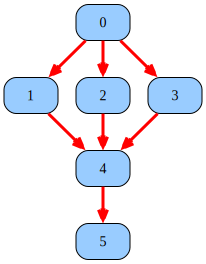

In [5]:
g.estyle = {'color':'red', 'penwidth': '3'}
print(g.estyle) # arrowhead is still present
g.view()

### static attribute values

Static attribute values are **string** constants. When used for vertex or edge styles, they apply to all vertices and edges, respectively. In the example above, `penwidth` has a static value. Note that all static values must be defined as strings, even when considering integer and floating-point values.

Let us change the label of the vertex to "node" using a static attribute value, and set the edge color back to the default (`None`).

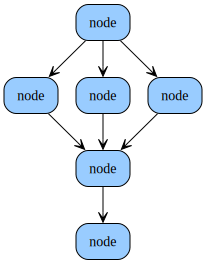

In [6]:
g.vstyle = {'label':'node'}
g.estyle = {'color': None, 'penwidth': "1"}
g.view()

### dynamic attribute values

As demonstrated, it can be beneficial to modify attribute values based on specific vertex or edge elements, such as the `label` attribute mentioned above. In these cases, instead of setting a static string, we assign a function that is evaluated when the graph is rendered. These function values are known as dynamic attribute values, and they must return a string that corresponds to the attribute value.

The signature of these functions varies depending on the style element:
- For graph style: `fn(g: HGraph) -> str`
- For vertex style: `fn(g: HGraph, vx: int) -> str`
- For edge style: `fn(g: HGraph, edge: (int, int)) -> str`

In the following example, we modify the vertex label to follow the pattern A->B->C, where A represents vertex 0, and so on. We also set the label for the edge.

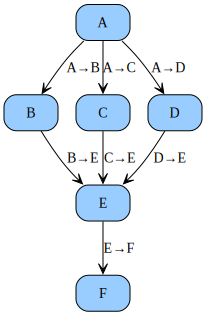

In [7]:
def id_to_label(vx):
    return chr(vx+ord('A'))

g.vstyle = {'label': lambda g, vx: id_to_label(vx)}
g.estyle = {'label': lambda g, e: f"{id_to_label(e[0])}→{id_to_label(e[1])}"}

g.view()

### multi-part vertex labels 

By default, vertices use `Mrecord` style to support multi-part labels. More specifically, in Graphviz, the `Mrecord` shape is used to create nodes that can have multiple rectangular regions, each containing a label. This is useful to display multiple pieces of information in a single node. One can switch between horizontal and vertical layouts by enclosing fields in braces `{...}`. By default, the top-level orientation in a `Mrecord` is horizontal. For instance, a `Mrecord` with the label `"A | B | C | D"` will display four fields from left to right.  However, if these fields are enclosed in braces, like `"{A | B | C | D}"`, they will be displayed from top to bottom. 

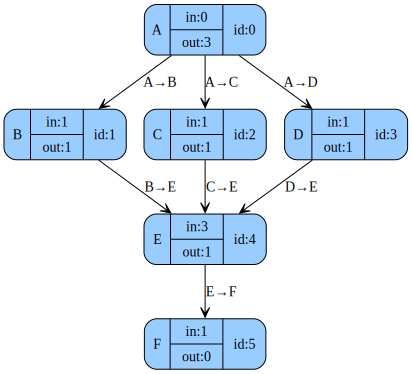

In [8]:
g.vstyle = {'label': lambda g, vx: "%s|{in:%d|out:%d}|id:%d" %
                                   (id_to_label(vx), g.num_in_vx(vx), g.num_out_vx(vx), vx)}
g.view()

### clustering

Clustering allows grouping vertices into distinct rectangular sections. To set up clustering, three style elements need to be configured:

- `g.style['nclusters']`: This sets the number of clusters.
- `g.style['cluster']`: This defines the style format of the clusters.
- `g.vstyle['cluster']`: This determines which cluster a vertex belongs to. The first cluster is identified as "0". If a vertex is set to `None`, it means the vertex does not belong to any cluster.

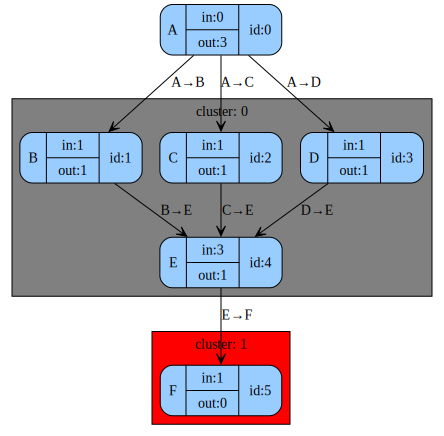

In [9]:
g.style['nclusters'] = '2'
# cluster 0: bgcolor: gray
# cluster 1: bgcolor: red
g.style['cluster'] = lambda g, c: {"label": f'cluster: {c}', "bgcolor": "gray" if c == 0 else "red"}
# 0: None
# 1--4: cluster 0
# 5: cluster 1
g.vstyle['cluster'] = lambda g, vx: None if vx == 0 else 0 if vx <= 4 else 1
g.view()

## custom rendering

As demonstrated, HGraphs can internally encode visual styles. However, there may be instances where we want to modify the rendering—for example, during an analysis—without altering the graph's internal style.

In such cases, the renderer supports `gstyle`, `vstyle`, and `estyle` parameters. These parameters can be used to update the internal graph styles without permanently changing them. You can use these parameters in the `g.view(...)` or `viewer.add_graph(...)` methods.

In the following example, we render the graph without clusters. It is important to note that while the visual representation changes, the underlying graph style remains clustered.

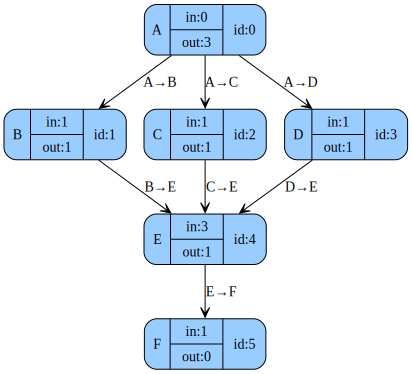

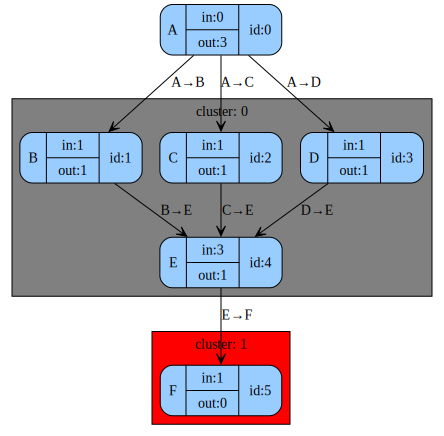

In [10]:
g.view(gstyle={'nclusters': 0}, title='custom rendering')
g.view(title='internal style rendering')

Moreover, original attribute values can be modified using `wrapper` attributes. These attributes are prefixed with a `#`, and are defined by a function that takes a string value as input. This function can then alter the string value. To demonstrate this, let us include the cluster number in each vertex's label, using the original label value.

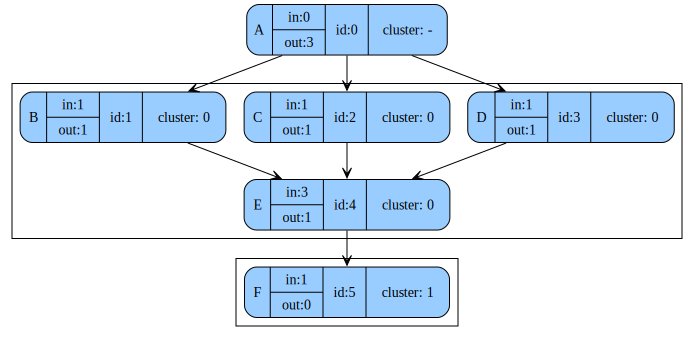

In [11]:
g.view(gstyle={'cluster': lambda g, c: {}}, # remove cluster style
       estyle={'label': None }, # remove label from edges
       vstyle={'#label': lambda g, v, s: f'{s} | cluster: %s' % ("-" if v == 0 else "0" if v <= 4 else "1")})

## subgraph

Specific parts of the graph can be rendered by using the following parameters:
- `vs`: This is a list of vertices that should be included in the rendering. By default, all vertices are included.
- `induced`: This parameter determines whether to include edges that connect two vertices in the `vs` list. By default, this is set to `True`, meaning all edges are included.

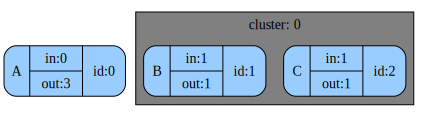

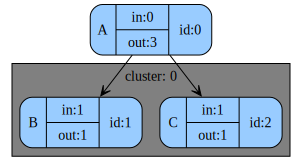

In [12]:
viewer = WebView()
g.estyle = {'label': None}
viewer.add_graph(g, vs=[0, 1, 2], induced=False, title="subgraph (induced=False)")
viewer.add_graph(g, vs=[0, 1, 2], induced=True, title="subgraph (induced=True)")

viewer.run()

## outputs
An HGraph can be rendered into various formats using the `g.render()` method. In addition to all the rendering parameters mentioned above, it also accepts the following parameters to control the output:
- `format`: specifies the output format. Options include `pdf`, `png`, `dot`, and `svg`.
- `pipe`: if set to True, this returns a string containing the output in the desired format. If False, the output is written to a file.
- `filename`: defines the name of the file where the output is stored when `pipe` is set to False.